In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import numpy as np

from dataset import ObjectsPointCloudDataset
from model.network import Network
from torchvision import transforms


In [2]:
CSV_PATH = '/home/flavio/Scrivania/dataset.csv'
DATASET_PATH = '/home/flavio/Documenti/Datasets/ShapeNetCore'


## Example of elements and images

In [3]:
points_frame = pd.read_csv(CSV_PATH)
n=1
img_name = points_frame.iloc[n, 0]
points = points_frame.iloc[n, 1:]
points = np.asarray(points, dtype=float).reshape(-1, 3)

Image name: 03948459/b4341b7259f66d529f433921788191f3/renderings/15.png
Points shape: (1024, 3)


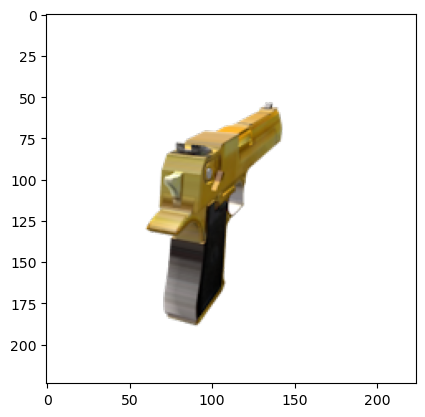

In [4]:
print('Image name: {}'.format(img_name))
print('Points shape: {}'.format(points.shape))
def show_points(image, points):
    """Show image with landmarks"""
    plt.imshow(image)

plt.figure()
show_points(io.imread(os.path.join(DATASET_PATH, img_name)),
               points)
plt.show()

### Dataset and DataLoader

In [5]:
# Load data from CSV
df = pd.read_csv(CSV_PATH)

# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor()  # Convert the PIL image to a PyTorch tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std (example for ImageNet)
])

# Create dataset objects
train_dataset = ObjectsPointCloudDataset(train_data, DATASET_PATH, transform=transform)
test_dataset = ObjectsPointCloudDataset(test_data, DATASET_PATH, transform=transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



### Network model

#### TODO
Fare il trainign di loop. Ricorda di spostare tutto sulla GPU se disponibile

In [6]:
model = Network(input_channels=4)
if torch.cuda.is_available():
    model = model.to('cuda')  # Move your model to GPU if available


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
i = Image.open(os.path.join(DATASET_PATH,
                                df.iloc[0, 0])).convert('RGBA')
i.show()

In [8]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, point_clouds in train_loader:
        if torch.cuda.is_available():
            images = images.to('cuda')
            point_clouds = point_clouds.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        
        # Reshape outputs to match the ground truth point cloud
        # outputs = outputs.view(-1, 1024, 3)
        
        loss = criterion(outputs, point_clouds)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Final ENCODER shape:     torch.Size([32, 512, 8, 8])
Final x shape:     torch.Size([32, 1024, 3])


RuntimeError: Found dtype Double but expected Float